### Main Config

In [1]:
# Data_path = "/content/drive/MyDrive/Behavioral/Data"
# Models_path = "/content/drive/MyDrive/Behavioral/Models"
Data_path = "D:/Projects/Fortune_company_opinion_mining/Data"
Models_path = "D:/Projects/Fortune_company_opinion_mining/Models"

random_seed = 42
notebook_env = "test" # "test" for experimenting, "final" for final execution

import os
import sys

### Google Colab Configs

In [2]:
# !pip uninstall -y pandas numpy scipy
# !pip install pandas scipy==1.10.1

In [3]:
# %%capture
# !pip install emoji
# !pip install langdetect
# !pip install nltk
# !pip install tqdm
# !pip install langid
# !pip install scipy==1.10.1
# !pip install genism
# !pip install pyLDAvis==3.4.1
# !pip install gensim
# !pip install scipy --upgrade

# Project

In [4]:
import os
import pandas as pd
import spacy
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from langdetect import detect, detect_langs
import numpy as np
import pyLDAvis
import pyLDAvis.gensim
import kagglehub
import os
import json
from corextopic import corextopic as ct
from gensim.models import LdaModel
from gensim.models import LdaModel
from gensim.corpora.dictionary import Dictionary
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm
tqdm.pandas()

### Defined functions

#### Input Output

In [5]:
def read_raw_main(Data_path):

    dataset_name = "10Mar2025.json"
    dataset_path = os.path.join(Data_path, dataset_name)

    if os.path.isfile(dataset_path):
        with open(dataset_path, 'r') as f:
            data = json.load(f)
        print("Dataset loaded from drive.")
    else:
        print("Downloading from Kaggle ...")
        fort_list_path = kagglehub.dataset_download("jarredgaudineer/social-media-posts-fortune-1000-companies")
        print("Dataset downloaded from kaggle.")

        # Load the wanted file
        temp_path = os.path.join(fort_list_path, "10Mar2025.json")
        
        with open(Data_path, 'r') as f:
            data = json.load(f)

        # Save the data into drive
        with open(dataset_path, 'w') as f:
            json.dump(data, f)
        print("Dataset saved to drive.")

    return data

def read_raw_complement():
    # The complementary Dataset
    dataset_name = "fortune1000_2024.csv.csv"
    dataset_path = os.path.join(Data_path, dataset_name)

    if os.path.isfile(dataset_path):
        fortune_company_list = pd.read_csv(dataset_path)
        print("Dataset loaded from drive.")
    else:
        fort_list_path = kagglehub.dataset_download("jeannicolasduval/2024-fortune-1000-companies")
        print("Dataset downloaded from kaggle.")
        fortune_company_list = pd.read_csv(os.path.join(fort_list_path, "fortune1000_2024.csv"))
        fortune_company_list.to_csv(dataset_path)
        print("Dataset saved to drive.")


def kaggle_save(dataset_name, data_path):
    print("Downloading from Kaggle ...")
    temp_path = kagglehub.dataset_download("khalilvandian/enriched-social-media-posts-fortune-1000-companies")
    temp_dataset_path = os.path.join(temp_path, dataset_name)

    enriched_data = pd.read_csv(temp_dataset_path)

    # Save to local data dir
    dataset_path = os.path.join(data_path, dataset_name)
    enriched_data.to_csv(dataset_path)

    return enriched_data


def read_enriched(data_path):
    dataset_name = "enriched_social-media-posts-fortune-1000-companies_data.csv"
    dataset_path = os.path.join(data_path, dataset_name)

    if os.path.isfile(dataset_path):
        enriched_data = pd.read_csv(dataset_path, index=False)
        print('Loaded file from data dir.')

    else:
        enriched_data = kaggle_save(dataset_name, data_path)

    return enriched_data

def read_preprocessed(data_path, notebook_env):

    if notebook_env == "test":
        dataset_name = "complete_preprocessed_companyData.csv"
    else:
        dataset_name = "complete_preprocessed_companyData_allData.csv"

    dataset_path = os.path.join(data_path, dataset_name)

    if os.path.isfile(dataset_path):
        temp_df = pd.read_csv(dataset_path, index_col=0)
        print("Dataset loaded from drive.")
        return temp_df
    else:
        return None
    
def read_tokenized(data_path, notebook_env):
    if notebook_env == "test":
        dataset_name = "spacy_tokenized_sample.pkl"
    else:
        dataset_name = "spacy_tokenized_allData.pkl"

    dataset_path = os.path.join(data_path, dataset_name)

    if os.path.isfile(dataset_path):
        tokenized_texts = pd.read_pickle(dataset_path)
        print("Loaded from drive.")
        return tokenized_texts
    else:
        return None

def load_lda_model(models_path):
    model_name = "GensimLdaModel_SpacyTokens_TopicCount20"
    # retrain with 20 topics or load back
    model_path_temp = os.path.join(models_path, model_name)

    if os.path.isfile(model_path_temp):
        lda_model = LdaModel.load(model_path_temp)
        return lda_model
    else:
        return None


#### Preprocessing

In [6]:
def preprocess_text(text, targets):

    # First Demojize Text
    edited_text = emoji.replace_emoji(text, '')

    # Mask company
    try:
        pattern = r'(?<![a-zA-Z])(?:' + '|'.join(re.escape(word) for word in targets if isinstance(word, str)) + r')(?![a-zA-Z])'
        if re.search(pattern, text, flags=re.IGNORECASE):
            edited_text = re.sub(pattern, "TargetedCompany", text, flags=re.IGNORECASE)
        else:
            edited_text = ""

    except Exception as e:
        raise

    # lower case
    edited_text = edited_text.lower()

    # remove links, mentions, hashtags
    edited_text = re.sub(r"http\S+|www\S+|@\w+|#\w+", '', edited_text)

    # Remove numbers
    edited_text = re.sub(r'\d+', '', edited_text)

    # Remove non ASCII
    edited_text = re.sub(r'[^\x00-\x7F]+', '', edited_text)

    # remove extra spaces
    edited_text = re.sub(r'\s+', ' ', edited_text).strip()

    # return if text is empty
    if edited_text == "":
        return edited_text

    # Remove non english
    try:
        # lang = detect(edited_text)
        lang, _ = langid.classify(edited_text)
        if lang != "en":
            edited_text = ""
    except Exception as e:
        # print(f"Error detecting language for text at index {index} and content:{edited_text}: {e}")
        edited_text = ""

    return edited_text

### Download Data from Kaggle/Load Data

In [5]:
# import sys

# # setting path
# sys.path.append('..')
# from src import ioFuncs

# ioFuncs.read_raw_main(Data_path=Data_path)

In [4]:
# columns = ["Company", "Text", "Source"]
# atts_temp = ["tweets", "comments", "posts"]
# source_dic = {"tweets": "Twitter", "comments": "Reddit-Comments", "posts": "Reddit-Posts"}
# mp_doc_list = []

# for company in data:
#   for text_list in atts_temp:
#     if text_list in company:
#       for text in company[text_list]:
#         mp_doc_list.append([company["company"], text["text"], source_dic[text_list]])


# data_df = pd.DataFrame(mp_doc_list, columns=columns)
# data_df

In [6]:
# enriched_data = pd.merge(fortune_company_list[["Company", "Ticker", "Sector", "Industry"]], data_df, left_on="Company", right_on="Company")
# enriched_data.sample(10, random_state=random_seed)

In [ ]:
# # compare unique companies in the enriched dataset and main dataset
# enriched_companies = enriched_data["Company"].unique()
# main_companies = data_df["Company"].unique()

# print(f"Number of companies in the enriched dataset: {len(enriched_companies)}")
# print(f"Number of companies in the main dataset: {len(main_companies)}")

Number of companies in the enriched dataset: 953
Number of companies in the main dataset: 953


In [5]:
# data_df = read_enriched(data_path=Data_path)
# data_df.head()

## Preprocessing the texts

In [6]:
# show duplicates
# duplicates = data_df[data_df.duplicated()]
# duplicates.sample(min(10, len(duplicates)), random_state=random_seed)

In [7]:
temp_df = read_preprocessed(data_path=Data_path, notebook_env=notebook_env)

if temp_df is None:
  # drop duplicates
  temp_df = data_df.drop_duplicates()
  temp_df.describe()

  ### Sample for Analysis
  # **Sampling of Enriched Data**: This is done to make experiments lighter, for final analysis all data will be used.
  if notebook_env == "test":
    sample_data_df = data_df.sample(50000, random_state=random_seed)
  elif notebook_env == "final":
    sample_data_df = data_df.copy()

  temp_df = sample_data_df.copy()

  def prprcss(row):
    try:
      return preprocess_text(row["Text"], [row["Company"], row["Ticker"]])
    except:
      print(row.to_markdown())
    

  temp_df["Text"] = temp_df.progress_apply(lambda row: prprcss(row), axis=1)
  temp_df

  temp_df = temp_df[temp_df["Text"] != ""]
  temp_df.describe()

  temp_df.to_csv(dataset_path)
  print("File saved to drive.")

else:
  print(temp_df.head())


Dataset loaded from drive.
         Company Ticker              Sector            Industry  \
52944    Comcast  CMCSA  Telecommunications  Telecommunications   
143656       Dow    DOW           Chemicals           Chemicals   
525390  Sinclair   SBGI               Media       Entertainment   
374514      Olin    OLN           Chemicals           Chemicals   
178759        3M    MMM           Chemicals           Chemicals   

                                                     Text           Source  
52944   same thing happened to me this week. police de...  Reddit-Comments  
143656  > stock futures tumbled sunday night to kick o...     Reddit-Posts  
525390  got some big names in the mid and fwd, feel my...     Reddit-Posts  
374514  not full true! i was playing with targetedcomp...  Reddit-Comments  
178759  this storm had to be some kind of divine punis...     Reddit-Posts  


In [8]:
temp_df.head()

,Company,Ticker,Sector,Industry,Text,Source
52944,Comcast,CMCSA,Telecommunications,Telecommunications,same thing happened to me this week. police de...,Reddit-Comments
143656,Dow,DOW,Chemicals,Chemicals,> stock futures tumbled sunday night to kick o...,Reddit-Posts
525390,Sinclair,SBGI,Media,Entertainment,"got some big names in the mid and fwd, feel my...",Reddit-Posts
374514,Olin,OLN,Chemicals,Chemicals,not full true! i was playing with targetedcomp...,Reddit-Comments
178759,3M,MMM,Chemicals,Chemicals,this storm had to be some kind of divine punis...,Reddit-Posts


## Vectorization and Lemmatization

In [9]:
target_filter = "targetedcompany"
nlp_pip = spacy.load("en_core_web_sm")

def tokenize_text(text):

  # tokenize with NLTK
  doc = nlp_pip(text)

  # remove punct and stopwords and targetCompany
  tokens = []
  for token in doc:
    if (not token.is_punct) and (not token.is_stop) and (token.text != target_filter):
      tokens.append(token.lemma_)

  return tokens

# def edit_tokens(doc_list):

#   # remove punct and stopwords and targetCompany
#   tokens = []
#   for token in doc_list:
#     if (not token.is_punct) and (not token.is_stop) and (token.text != target_filter):
#       tokens.append(token.lemma_)

#   return tokens

In [ ]:
# # tesing the tokenization
# sample = temp_df.sample(random_state=random_seed, n= 100)[["Text"]]
# sample["Tokens"] = sample[["Text"]].apply(lambda row: tokenize_text(row["Text"]), axis=1)
# sample

In [ ]:
# def print_tokenization(row):
#   test = textwrap.fill(row["Text"], width=150)
#   tokenized = textwrap.fill(", ".join(row["Tokens"]), width=150)
#   print(f"Main text: {test}, \n **************** \nTokenized Text: {tokenized}\n")


# sample.apply(lambda row: print_tokenization(row), axis=1)

In [ ]:

# temp = temp_df.sample(100, random_state=random_seed)["Text"]
# listOfDocs = list(tqdm(nlp_pip.pipe(temp), total=len(temp)))
# listOfTokens = pd.Series([token for token in listOfDocs])
# tokenized_texts = listOfTokens.progress_apply(lambda x: edit_tokens(x))

In [10]:
tokenized_texts = read_tokenized(Data_path, notebook_env)

if tokenized_texts is None:
  # # pass the texts through the spacy pipeline in a statistical manner
  # docGenerators = tqdm(nlp_pip.pipe(temp_df["Text"], batch_size=500), total=len(temp_df["Text"]))
  # listOfDocs = list(docGenerators)

  # # use generator to extract tokens
  # listOfTokens = pd.Series([token for token in listOfDocs])
  # tokenized_texts = listOfTokens.progress_apply(lambda x: edit_tokens(x))

  tokenized_texts = temp_df.progress_apply(lambda row: tokenize_text(row["Text"]), axis=1)
  tokenized_texts.to_pickle(dataset_path)
  print("Saved to drive.")

Loaded from drive.


In [11]:
tokenized_texts

0        [thing, happen, week, police, dept, say, call,...
1        [>, stock, future, tumble, sunday, night, kick...
2        [get, big, name, mid, fwd, feel, defence, ligh...
3        [true, play, early, hold, pretty, obviously, g...
4        [storm, kind, divine, punishment, cosmic, god,...
                               ...                        
35187    [gpa-, fine, adequate, sit, low, end, probably...
35188                 [sick, tired, talk, like, wtf, stop]
35189    [hello, r, train, m, painting, th, anniversary...
35190    [backline, control, hero, red, team, available...
35191    [company, location, british, columbia, salary,...
Length: 35192, dtype: object

In [12]:
def identical_analyzer(token):
  return token

vectorizer = CountVectorizer(analyzer=identical_analyzer, min_df=0.005, max_df=0.995)
bow = vectorizer.fit_transform(tokenized_texts)

In [13]:
len(vectorizer.vocabulary_)

1622

In [14]:
# dict of terms and their frequencies
term_frequencies = {}
feats = vectorizer.get_feature_names_out()
freqs = bow.toarray().sum(axis=0)

for feature, frequency in zip(feats, freqs):
  term_frequencies[feature] = frequency

wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(term_frequencies)

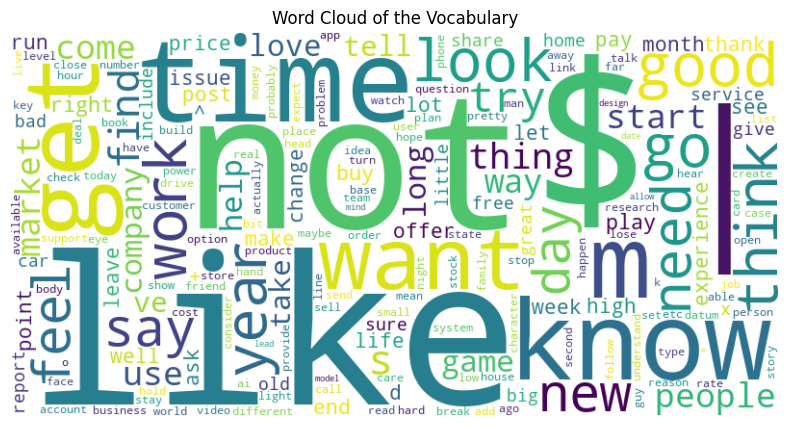

In [ ]:
# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title(f"Word Cloud of the Vocabulary")
plt.show()

## Topic Modeling The texts
Initially, we need to understand what sort of content we have. This will help deciding if we should go with data based topics or anchored topics.

In [15]:
dictionary = Dictionary(tokenized_texts)
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

In [ ]:
# topic_counts = range(2,30,2)

In [ ]:
# models = []
# c_v_coherence = []

# for i in tqdm(topic_counts):
#   # check if model is already in drive
#   model_path_temp = os.path.join(Models_path, "GensimLdaModel_SpacyTokens_TopicCount" + str(i))

#   if os.path.isfile(model_path_temp):
#     lda_model = LdaModel.load(model_path_temp)
#   else:
#     lda_model = LdaModel(
#         corpus=corpus,
#         id2word=dictionary,
#         num_topics=i,
#         random_state=random_seed,
#         passes=10,
#         iterations=50
#     )

#     # save the trained model
#     lda_model.save(model_path_temp)

#   # append the model to a list
#   models.append(lda_model)


#   cm = CoherenceModel(model=lda_model, texts=tokenized_texts, dictionary=dictionary, coherence='c_v')
#   c_v_coherence.append(cm.get_coherence())

# metrics = pd.DataFrame({"Topic_Count": list(topic_counts), "c_v": c_v_coherence})
# metrics.head()

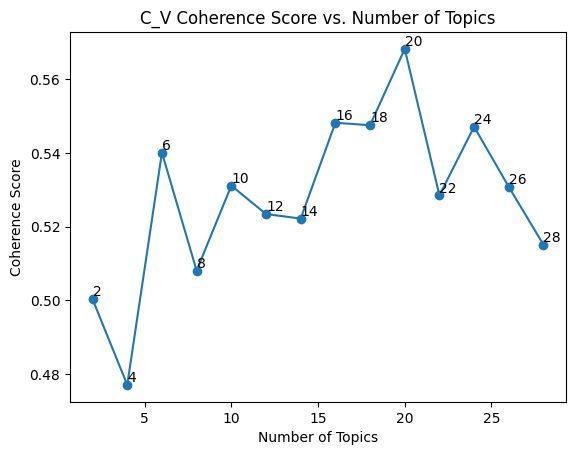

In [ ]:
# # plot coherence by the topic count
# import matplotlib.pyplot as plt

# plt.plot(metrics["Topic_Count"], metrics["c_v"], marker='o')
# plt.xlabel('Number of Topics')
# plt.ylabel('Coherence Score')
# plt.title('C_V Coherence Score vs. Number of Topics')

# for i, txt in enumerate(metrics["Topic_Count"]):
#   plt.text(metrics["Topic_Count"][i], metrics["c_v"][i], f'{txt}', ha='left', va='bottom') # Format label to 2 decimal places


- 1: ranting probably
- 2: Intimate fiction
- 3: Personal growth
- 4: Jobs (Mostly tech jobs)
- 5: Financial Markets
- 6: Personal finance
- 7: Potentially daily stories and personal narratives?!
- 8: Health issues
- 9: Online stores - Purchases
- 10: Gaming
- 11: Computer technology (similar to 15)
- 12: Company news / Market news
- 13: Political news and posts
- 14: Streaming channels and relevant content (YT, Prime, ...)
- 15: Computer technology and gaming hardware
- 16: Books, Movies, Fiction, ...
- 17: Subreddit moderaters and banners in reddit
- 18: Company applications and policies
- 19: Gaming
- 20: Lifestyle

In [16]:
lda_model = load_lda_model(Models_path)

if lda_model is None:
  # lda_model = LdaModel(
  #     corpus=corpus,
  #     id2word=dictionary,
  #     num_topics=20,
  #     random_state=random_seed,
  #     passes=10,
  #     iterations=50
  # )
  # # save the trained model
  # lda_model.save(model_path_temp)
  print("Trained model.")

pyLDAvis.enable_notebook()
# # top_model_index = metrics[metrics["Topic_Count"] == 20].index[0]
pyLDAvis.gensim.prepare(lda_model, corpus, dictionary, mds="mmds", R=50)

d:\Projects\Fortune_company_opinion_mining\venv\Lib\site-packages\sklearn\manifold\_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.064568  0.384031       1        1  23.772012
13     0.202398  0.358173       2        1   9.723552
2     -0.102749  0.368151       3        1   8.384601
12    -0.222454  0.179049       4        1   6.704488
15    -0.339257  0.090155       5        1   6.277585
14    -0.269343  0.299665       6        1   5.144641
4      0.331210  0.253573       7        1   4.717422
18    -0.084917  0.050949       8        1   4.662751
0      0.013462  0.190928       9        1   4.450746
3      0.236556  0.104525      10        1   4.400016
5     -0.017400 -0.161242      11        1   3.112514
10    -0.340853 -0.162900      12        1   3.107484
19    -0.437882 -0.056785      13        1   2.794187
9      0.191995 -0.153315      14        1   2.540940
8      0.251966 -0.391136      15        1   2.517355
6      0.383724 -0.165035      16        1   2.473189
16     0.409296 -0.010511      17        1   2.093947
1      0.056555 -0.409985      18        1   1.274038
11    -0.230224 -0.337997      19        1   1.169010
17    -0.096651 -0.430293      20        1   0.679520, topic_info=         Term          Freq         Total Category  logprob  loglift
959         $  21016.000000  21016.000000  Default  50.0000  50.0000
3910        |  11402.000000  11402.000000  Default  49.0000  49.0000
659       not  15913.000000  15913.000000  Default  48.0000  48.0000
1837   market   5605.000000   5605.000000  Default  47.0000  47.0000
1134        +   3900.000000   3900.000000  Default  46.0000  46.0000
...       ...           ...           ...      ...      ...      ...
1124  walmart     63.832045    194.554832  Topic20  -5.5079   3.8771
298     limit     93.416151   1101.195389  Topic20  -5.1270   2.5245
505   vanilla     57.864489    141.125864  Topic20  -5.6060   4.1000
1233   credit     71.680724   1449.128479  Topic20  -5.3919   1.9850
2856     rare     55.449770    254.644746  Topic20  -5.6486   3.4671

[2214 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
959        5  0.198372        $
959       12  0.003378        $
959       15  0.798197        $
1134       4  0.006410        +
1134       5  0.002051        +
...      ...       ...      ...
3910      15  0.999895        |
4439      15  0.989836  |:-|:-|
12993     14  0.992403      |ye
12994     14  0.982011     |yes
2494      17  0.991421       ||

[5564 rows x 3 columns], R=50, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 14, 3, 13, 16, 15, 5, 19, 1, 4, 6, 11, 20, 10, 9, 7, 17, 2, 12, 18])

In [ ]:
# topics = {
#     1: "ranting probably",
#     2: "Intimate fiction",
#     3: "Personal growth",
#     4: "Jobs (Mostly tech jobs)",
#     5: "Financial Markets",
#     6: "Personal finance",
#     7: "Potentially daily stories and personal narratives?!",
#     8: "Health issues",
#     9: "Online stores - Purchases",
#     10: "Gaming",
#     11: "Computer technology (similar to 15)",
#     12: "Company news / Market news",
#     13: "Political news and posts",
#     14: "Streaming channels and relevant content (YT, Prime, ...)",
#     15: "Computer technology and gaming hardware",
#     16: "Books, Movies, Fiction, ...",
#     17: "Subreddit moderaters and banners in reddit",
#     18: "Company applications and policies",
#     19: "Gaming",
#     20: "Lifestyle"
# }

# def select_topics(topic_list):
#     threshold = 0.1
#     topic_dic = {}
#     for topic_id, topic_score in topic_list:
#         topic_name = topics[topic_id + 1]

#         if topic_score >= threshold:
#             topic_dic[topic_name] = topic_score
    
#     if len(topic_dic) == 0:
#         return None
    
#     return topic_dic


# doc_topics.sample(10).apply(lambda x: select_topics(x))

25669    {'Health issues': 0.5770426, 'Gaming': 0.22135...
17614    {'Health issues': 0.6217838, 'Company news / M...
4878     {'Health issues': 0.21960923, 'Political news ...
32622    {'Personal growth': 0.19664723, 'Potentially d...
33149    {'Health issues': 0.4379301, 'Political news a...
20653    {'Health issues': 0.43119162, 'Gaming': 0.2024...
1723     {'Health issues': 0.662006, 'Gaming': 0.27796188}
23809    {'Potentially daily stories and personal narra...
1591     {'Health issues': 0.6334157, 'Gaming': 0.13667...
33572                            {'Lifestyle': 0.52496976}
dtype: object

### Eval and vis

In [ ]:
# # Count topics
# topic_counts = temp_df["Topic"].value_counts().sort_index()

# # Map the index to topic titles for labeling
# labels = [topic_titles[i] for i in topic_counts.index]

# # Plot with titles as x-axis labels
# plt.figure(figsize=(10, 6))
# plt.bar(labels, topic_counts.values)
# plt.xticks(rotation=45, ha='right')
# plt.title("Document Counts per Topic")
# plt.ylabel("Number of Documents")
# plt.tight_layout()
# plt.show()

In [ ]:
# # Group data by sector and topic, and count occurrences
# sector_topic_counts = temp_df.groupby(['Sector', 'Topic'])['Topic'].count().unstack()

# # Get sector and topic labels
# sectors = sector_topic_counts.index
# topic_labels = [topic_titles[i] for i in range(lda.n_components)]

# # Create the stacked bar chart
# fig, ax = plt.subplots(figsize=(12, 6))

# # Plot bars for each topic within each sector
# bottom = [0] * len(sectors)  # Initialize bottom for stacking
# for i, topic_label in enumerate(topic_labels):
#     ax.bar(sectors, sector_topic_counts[i], label=topic_label, bottom=bottom)
#     bottom = [bottom[j] + sector_topic_counts[i][j] for j in range(len(sectors))]

# # Set chart labels and formatting
# ax.set_xlabel("Sector")
# ax.set_ylabel("Number of Documents")
# ax.set_title("Topic Distribution Across Sectors")
# ax.legend(title="Topics", bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside the plot
# plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
# plt.tight_layout()
# plt.show()

In [ ]:
# # Assuming your DataFrame is named 'temp_df' and contains 'Source' and 'Topic' columns

# # Group data by source and topic, and count occurrences
# source_topic_counts = temp_df.groupby(['Source', 'Topic'])['Topic'].count().unstack()

# # Get source and topic labels
# sources = source_topic_counts.index
# topic_labels = [topic_titles[i] for i in range(lda.n_components)]  # Assuming you have topic_titles defined

# # Create the stacked bar chart
# fig, ax = plt.subplots(figsize=(12, 6))

# # Plot bars for each topic within each source
# bottom = [0] * len(sources)  # Initialize bottom for stacking
# for i, topic_label in enumerate(topic_labels):
#     ax.bar(sources, source_topic_counts[i], label=topic_label, bottom=bottom)
#     bottom = [bottom[j] + source_topic_counts[i][j] for j in range(len(sources))]

# # Set chart labels and formatting
# ax.set_xlabel("Source")
# ax.set_ylabel("Number of Documents")
# ax.set_title("Topic Distribution Across Sources")
# ax.legend(title="Topics", bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside the plot
# plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
# plt.tight_layout()
# plt.show()

In [ ]:
# # Get feature names (words) from the vectorizer
# feature_names = vectorizer.get_feature_names_out()

# # Create a dictionary to store the word clouds for each topic
# topic_wordclouds = {}

# # Iterate through each topic
# for topic_index in range(lda.n_components):
#     # Get documents belonging to the current topic
#     topic_documents = temp_df[temp_df["Topic"] == topic_index]["Text"]

#     # Create a frequency dictionary for words in the topic documents
#     word_frequencies = {}
#     for doc in topic_documents:
#         for word in tokenize_text(doc):  # Use your tokenize_text function
#             if word in feature_names:
#                 word_frequencies[word] = word_frequencies.get(word, 0) + 1

#     # Create a WordCloud object
#     wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_frequencies)

#     # Store the word cloud in the dictionary
#     topic_wordclouds[topic_index] = wordcloud

#     # Display the word cloud
#     plt.figure(figsize=(10, 5))
#     plt.imshow(wordcloud, interpolation="bilinear")
#     plt.axis("off")
#     plt.title(f"Word Cloud for Topic {topic_index}: {topic_titles[topic_index]}")  # Assuming you have topic_titles
#     plt.show()


## Anchored Topic Modeling of Documents

### Setup All Docs for Topic Selection

In [17]:
notebook_env = "final"

In [18]:
docs_df = read_preprocessed(data_path=Data_path, notebook_env=notebook_env)

Dataset loaded from drive.


In [61]:
company_counts = docs_df["Company"].value_counts()
print(company_counts)

Company
Tesla                            6841
Amazon                           6378
FMC                              6350
Apple                            5558
Airbnb                           5194
                                 ... 
Summit Materials                    1
AvalonBay Communities               1
Rackspace Technology                1
Energizer Holdings                  1
Allison Transmission Holdings       1
Name: count, Length: 919, dtype: int64


In [19]:
tokenized_texts = read_tokenized(Data_path, notebook_env)

Loaded from drive.


In [67]:
def identical_analyzer(token):
  return token

vectorizer = CountVectorizer(analyzer=identical_analyzer, min_df=0.005, max_df=0.995)
bow = vectorizer.fit_transform(tokenized_texts)
vocab = vectorizer.get_feature_names_out()

In [21]:
len(vectorizer.vocabulary_)

1623

### Semi Supervised Topic Modeling

In [74]:
# 2) Define your 5 anchored topic word‑lists
anchors = [
    # Politics
    ['election', 'government', 'vote', 'policy', 'politics', 'president'],

    # Lifestyle
    ['food', 'travel', 'fitness', 'routine', 'hobby', 'style'],

    # Financial markets
    ['stock', 'market', 'investing', 'shares', 'portfolio', 'price'],

    # Tech & Gaming (combined)
    ['computer', 'hardware', 'cpu', 'ram', 'laptop', 'build',
     'game', 'play', 'gamer', 'console', 'pc', 'xbox'],

    # Job postings
    ['job', 'career', 'hiring', 'resume', 'linkedin', 'apply']
]

# 3) Decide how many “free” topics (to ignore later)
n_free_topics = 4

# 4) Instantiate and fit Corex
corex_model = ct.Corex(n_hidden=len(anchors) + n_free_topics, seed=42)
corex_model.fit(
    bow,
    words=vocab,
    anchors=anchors,
    anchor_strength=5
)

# 5) Get the per-doc, per-topic probability matrix
#    transform(..., details=True) returns (p_y_given_x, log_z)
probs, _ = corex_model.transform(bow, details=True)  # shape = (n_docs, n_hidden)

# 6) Keep only the first 5 columns (our anchored topics)
anchor_probs = probs[:, :len(anchors)]                # shape = (n_docs, 5)

# 7) For each doc, find best anchor and its probability
best_idx  = anchor_probs.argmax(axis=1)               # values in {0,1,2,3,4}
best_prob = anchor_probs.max(axis=1)                  # floats in [0,1]

# 8) Add these predictions back into your DataFrame
docs_df['pred_topic'] = best_idx
docs_df['pred_prob']  = best_prob

# 9) Filter by a confidence threshold (e.g. >0.5)
threshold = 0.5
filtered_df = docs_df[docs_df['pred_prob'] > threshold].copy()

# 10) (Optional) Map numeric codes to human-readable labels
topic_names = {
    0: 'Politics',
    1: 'Lifestyle',
    2: 'FinMkts',
    3: 'TechGaming',
    4: 'Jobs'
}
filtered_df['pred_topic_name'] = filtered_df['pred_topic'].map(topic_names)

In [79]:
filtered_df.head()

,Company,Ticker,Sector,Industry,Text,Source,pred_topic,pred_prob,pred_topic_name
0,Walmart,WMT,Retailing,General Merchandisers,$googl $goog $targetedcompany google and targe...,Twitter,2,0.999999,FinMkts
18,Walmart,WMT,Retailing,General Merchandisers,check out the season champs! they dominated th...,Twitter,2,0.999999,FinMkts
32,Walmart,WMT,Retailing,General Merchandisers,i've heard about targetedcompany's weird teamw...,Reddit-Comments,4,0.999999,Jobs
43,Walmart,WMT,Retailing,General Merchandisers,any targetedcompany but the sparkman drive sto...,Reddit-Comments,1,0.999999,Lifestyle
45,Walmart,WMT,Retailing,General Merchandisers,"my targetedcompany is missing over fugglers, i...",Reddit-Comments,1,0.999999,Lifestyle


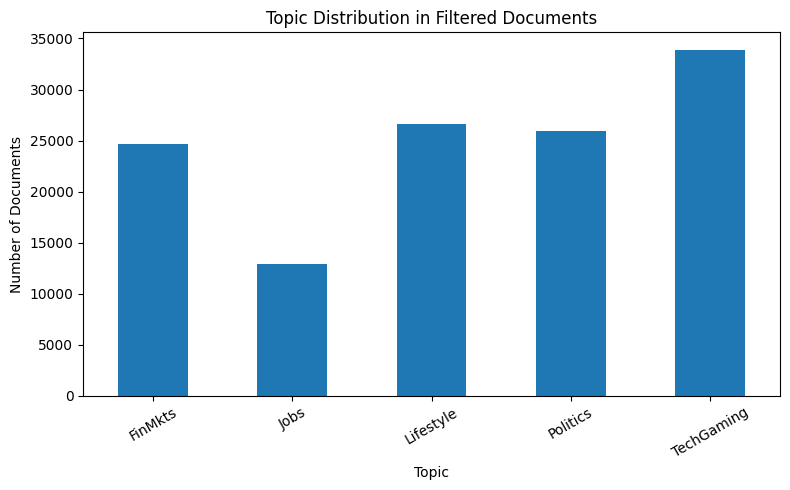

In [78]:
import matplotlib.pyplot as plt

topic_counts = filtered_df['pred_topic_name'].value_counts().sort_index()
plt.figure(figsize=(8, 5))
topic_counts.plot(kind='bar')
plt.xlabel('Topic')
plt.ylabel('Number of Documents')
plt.title('Topic Distribution in Filtered Documents')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

### Clustering

In [80]:
selected_companies = ["Tesla", "Amazon", "FMC", "Apple", "Airbnb"]

filtered_selected_df = filtered_df[filtered_df["Company"].isin(selected_companies)].copy()
filtered_selected_df.head()

,Company,Ticker,Sector,Industry,Text,Source,pred_topic,pred_prob,pred_topic_name
6354,Amazon,AMZN,Retailing,Internet Services and Retailing,"in years, $targetedcompany will likely continu...",Twitter,0,0.999999,Politics
6360,Amazon,AMZN,Retailing,Internet Services and Retailing,targetedcompany canada $targetedcompany glad l...,Twitter,2,0.999999,FinMkts
6361,Amazon,AMZN,Retailing,Internet Services and Retailing,targetedcompany canada $targetedcompany ecobee...,Twitter,2,0.999999,FinMkts
6364,Amazon,AMZN,Retailing,Internet Services and Retailing,portfolio & watchlist going into holdings: $ta...,Twitter,2,0.999999,FinMkts
6369,Amazon,AMZN,Retailing,Internet Services and Retailing,this is a fakespot reviews analysis bot. fakes...,Reddit-Comments,0,0.999998,Politics


#### Sentence Tokenization

In [58]:
# temp = docs_df.sample(n=1000, random_state=random_seed).copy()

sentences_df = tokenize_sentences(docs_df, str("Text"))
sentences_df

Tokenizing sentences: 100%|██████████| 1728/1728 [1:34:00<00:00,  3.26s/it]  


,original_idx,sentence
0,0,$googl $goog $targetedcompany google and targe...
1,1,can $phnix become the first meme coin to dethr...
2,2,targetedcompany $targetedcompany the laughing ...
3,3,some of the most iconic businesses ever .
4,3,$mcd - mcdonalds .
...,...,...
2782418,591336,million its holding
2782419,591337,clear channel outdoor hldgs $targetedcompany s...
2782420,591338,angelo gordon &amp; company lp maintains holdi...
2782421,591339,clear channel outdoor hldgs $targetedcompany s...


In [ ]:
# sentence_tokenizations_allData_path = os.path.join(Data_path, "sentence_tokenizations_allData_df.csv")
# sentences_df.to_csv(sentence_tokenizations_allData_path, index=False)

In [82]:
# Select sentences whose document exists in filtered_selected_df
selected_idxs = set(filtered_selected_df.index)
filtered_sentences = sentences_df[sentences_df['original_idx'].isin(selected_idxs)].copy()

# Map company and topic name from filtered_selected_df
filtered_sentences['Company'] = filtered_sentences['original_idx'].map(filtered_selected_df['Company'])
filtered_sentences['Topic_Name'] = filtered_sentences['original_idx'].map(filtered_selected_df['pred_topic_name'])

# Final DataFrame: sentence, company name, topic name
result_df = filtered_sentences[['sentence', 'Company', 'Topic_Name']]
result_df.head()

,sentence,Company,Topic_Name
22686,"in years, $targetedcompany will likely continu...",Amazon,Politics
22687,heres a breakdown of how targetedcompany could...,Amazon,Politics
22688,e-commerce expansion targetedcompanys dominanc...,Amazon,Politics
22689,ubiquitous online shopping platform: targetedc...,Amazon,Politics
22690,"with its vast selection, fast delivery, and ev...",Amazon,Politics


In [84]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import numpy as np

# Filter sentences for Amazon
amazon_sentences = result_df[result_df['Company'] == 'Amazon']

# Load the embedding model
embedder = SentenceTransformer('all-mpnet-base-v2')

# Store clustering results
cluster_results = {}

# For each topic_name, embed and cluster
for topic in amazon_sentences['Topic_Name'].unique():
    topic_df = amazon_sentences[amazon_sentences['Topic_Name'] == topic]
    sentences = topic_df['sentence'].tolist()
    if len(sentences) < 2:
        continue  # Skip if not enough sentences to cluster

    # Embed sentences
    embeddings = embedder.encode(sentences, batch_size=64, show_progress_bar=True)

    # Choose number of clusters (e.g., 5 or min(5, n_samples))
    n_clusters = min(5, len(sentences))
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(embeddings)

    # Add cluster labels to DataFrame
    topic_df = topic_df.copy()
    topic_df['cluster'] = labels
    cluster_results[topic] = topic_df

# Example: cluster_results['Politics'] contains clustered Amazon sentences for 'Politics'

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

d:\Projects\Fortune_company_opinion_mining\venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\khali\.cache\huggingface\hub\models--sentence-transformers--all-mpnet-base-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/271 [00:00<?, ?it/s]

Batches:   0%|          | 0/104 [00:00<?, ?it/s]

Batches:   0%|          | 0/55 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/70 [00:00<?, ?it/s]

In [86]:
# Show 50 samples of each cluster for each combo of Amazon and topic
for topic, topic_df in cluster_results.items():
    print(f"\n=== Topic: {topic} ===")
    for cluster_id in sorted(topic_df['cluster'].unique()):
        print(f"\n--- Cluster {cluster_id} ---")
        samples = topic_df[topic_df['cluster'] == cluster_id].sample(n=min(50, len(topic_df[topic_df['cluster'] == cluster_id])), random_state=random_seed)
        for idx, row in samples.iterrows():
            print(f"{row['sentence']}")


=== Topic: Politics ===

--- Cluster 0 ---
don't let someone fool you into thinking you imagined things.
although their 'large' is generous, extra-large breeds may require the xxl dog bed.**.
for those of you without a village, i totally commiserate with you.
i reached out to mods again who passed on the info for me but didnt hear anything from him, and said its up to jj to respond (fair imo) (img ).
the woman had put down her book and smiled, hi katie, glad you could join us.
whether youre flying halfway across the globe or driving to a nearby town, the experiences and people met turn each journey into a collection of stories.
trump and his minions lied to the maga people.**
i look forward to hearing from you soon.
they can be the perfect companion on your travels, pushing you to explore hidden gems and experience the world with a sense of awe and wonder.
i have to credit an amazing teacher of mine for making me aware of this stuff - andrew bartzis the galactic historian.
join me!
if